In [1]:
%matplotlib inline
import seaborn as sns
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import pysal as ps
import mplleaflet

In [2]:
# This is our main data frame, containing both geometry and 
# attributes exported from CartoDB

data = gpd.read_file('neighborhood_nta_census.geojson')

In [3]:
# This is only for the shapes that will be used by PySAL to 
# build the spatial weights matrix

psGeom = ps.open('neighborhood_nta_census/neighborhood_nta_census.shp', 'r')

In [4]:
# We are building the spatial weight matrix and using the 
# neighborhood names as IDs of the matrix. Noted that we
# running a 'queen', shared vertices, neighborhood test.

W = ps.buildContiguity(psGeom, criterion='queen', ids=data['ntaname'].values.tolist())

In [5]:
type(W)

pysal.weights.weights.W

In [6]:
# Let's see how West Village is connected to other neighborhoods.
# Notice the weights.

W['West Village']

{u'Chinatown': 1.0,
 u'East Village': 1.0,
 u'Gramercy': 1.0,
 u'Hudson Yards-Chelsea-Flatiron-Union Square': 1.0,
 u'SoHo-TriBeCa-Civic Center-Little Italy': 1.0}

In [7]:
# Now we would like to standardize all the weights. This can be 
# done by specifying 'R' as the matrix transformation. Then, let's
# look again the neighbors of the West Village. All the weights
# should add up to 1.

W.transform = 'R'
W['West Village']

{u'Chinatown': 0.2,
 u'East Village': 0.2,
 u'Gramercy': 0.2,
 u'Hudson Yards-Chelsea-Flatiron-Union Square': 0.2,
 u'SoHo-TriBeCa-Civic Center-Little Italy': 0.2}

In [8]:
# Next, we're going to perform a spatial autocorrelation on the
# percent column. We first standardize the values by subtracting
# the mean and divide by the standard deviation.

Y = data['percent'].values
Y = (Y-Y.mean())/Y.std() # <<<---- normalization

In [9]:
Y[:5]

array([-1.20582324,  1.3977757 , -1.66891397,  0.53333969, -0.47516899])

In [10]:
# and then compute the spatial lag for all neighborhoods based
# on the spatial weight matrix. We also store this as a column
# named 'w_percent' in the original table.

sl = ps.lag_spatial(W, Y)
data['w_percent'] = sl

In [11]:
data.head()

borocode  boroname  cartodb_id  countyfips  \
0         3  Brooklyn           1          47   
1         4    Queens           2          81   
2         2     Bronx           3           5   
3         2     Bronx           4           5   
4         3  Brooklyn           5          47   

                                            geometry ntacode  \
0  (POLYGON ((-73.888285 40.646722, -73.888292000...    BK93   
1  (POLYGON ((-73.76809900000001 40.597846, -73.7...    QN12   
2  (POLYGON ((-73.872872 40.785975, -73.872885 40...    BX98   
3  (POLYGON ((-73.88439 40.822967, -73.884361 40....    BX27   
4  (POLYGON ((-73.888339 40.64671, -73.888353 40....    BK50   

                    ntaname  percent  pop_2000  pop_2010  pop_diff  \
0             Starrett City     -8.7     14621     13354     -1267   
1  Hammels-Arverne-Edgemere     16.6     31645     36885      5240   
2             Rikers Island    -13.2     12780     11091     -1689   
3               Hunts Point      8.2     25142     27204      2062   
4                  Canarsie     -1.6     85058     83693     -1365   

      shape_area    shape_leng  w_percent  
0  11598945.8236  17414.781633   0.142285  
1  61904116.8013  83820.120650   0.121703  
2  18154595.7962  18903.346271  -0.310515  
3  49734670.5573  44778.618995   0.836921  
4  82015446.6700  43701.791058  -0.318747

In [12]:
# Execute the Moran's I calculation

mi = ps.Moran(Y, W)

In [13]:
# This is the Moran's I value, that would tell us whether population
# changes in New York are clustered, or not.

mi.I

0.17081223260260914

In [14]:
# Check the p-value of the calculation. This has to be < 0.05 for our
# calculation to be statistically significant.

mi.p_sim

0.001

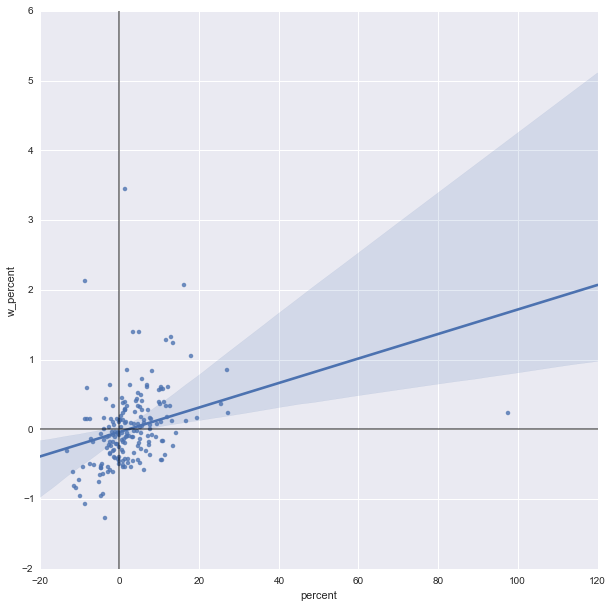

In [15]:
# It's time to look at the Moran Scatter Plot to inspet the results

f, ax = plt.subplots(1, figsize=(10,10))
sns.regplot(x='percent', y='w_percent', data=data)
plt.axvline(0, c='k', alpha=0.5)
plt.axhline(0, c='k', alpha=0.5)
plt.show()

In [22]:
#### THE BELOW CODE SHOULD WORK FOR MOST INSTALLATION
f, ax = plt.subplots(1, figsize=(10,10))
data.plot(column='w_percent', scheme='QUANTILES', k=7, alpha=1, colormap='YlOrRd')
mplleaflet.display(fig=f, crs=data.crs)

#### BUT IF NOT, PLEASE USE THE BELOW INSTEAD (and comment the previous blob)
# data.plot(column='w_percent', scheme='QUANTILES', k=7, alpha=1.0, colormap='YlOrRd', figsize=(10,10))
# mplleaflet.display(crs=data.crs)

In [23]:
# Now, let's look at local indicator. Overall, we see some
# trends, but not so strong. Maybe a local indicator test
# could help us see in details how things are correlated.
# We run the Moran's LISA calculation provided by PySAL.

lisa = ps.Moran_Local(Y, W)

In [27]:
lisa.q

array([2, 1, 3, 1, 3, 2, 1, 3, 3, 4, 1, 4, 3, 3, 1, 3, 2, 1, 1, 3, 1, 2, 2,
       3, 4, 3, 3, 3, 3, 3, 1, 3, 3, 1, 1, 1, 1, 3, 3, 2, 1, 4, 4, 1, 3, 2,
       3, 3, 3, 3, 4, 4, 3, 1, 3, 4, 2, 3, 3, 3, 3, 3, 1, 4, 1, 3, 4, 3, 4,
       3, 4, 2, 2, 1, 3, 3, 3, 3, 1, 2, 2, 1, 3, 3, 3, 2, 1, 1, 1, 4, 2, 3,
       3, 3, 3, 2, 1, 3, 2, 1, 2, 3, 3, 1, 1, 1, 2, 3, 3, 1, 3, 3, 1, 4, 4,
       2, 2, 3, 2, 3, 1, 3, 4, 3, 4, 4, 4, 2, 3, 1, 1, 3, 4, 2, 3, 1, 3, 1,
       4, 1, 2, 3, 2, 3, 2, 3, 2, 2, 1, 4, 2, 1, 3, 1, 3, 1, 2, 1, 2, 2, 4,
       4, 3, 4, 3, 3, 3, 4, 1, 3, 3, 3, 1, 3, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1,
       1, 3, 4, 2, 3, 4])

In [24]:
# Let's narrow down to those neighborhoods that are
# statistically significant.

S = lisa.p_sim < 0.05

In [28]:
S

array([False, False, False,  True, False, False, False, False,  True,
       False, False, False, False, False, False, False, False,  True,
        True,  True, False, False, False, False,  True, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False,  True, False, False,  True, False, False,
       False, False,  True, False, False, False, False, False, False,
        True, False, False,  True,  True, False,  True, False, False,
        True, False, False,  True, False, False,  True, False, False,
       False, False, False,  True, False, False, False,  True,  True,
       False,  True, False,  True, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False,  True, False, False, False,  True, False, False,
       False, False,

In [29]:
# And which quadrants they belong to

Q = lisa.q

In [30]:
# Next, we'll turn those into a GeoDataFrame for visualization.

records = map(lambda x: (data.iloc[x]['ntaname'], Q[x], data.geometry.iloc[x]),
              [i for i,s in enumerate(S) if s])


gdata = gpd.GeoDataFrame(records, columns=('ntaname', 'quadrant', 'geometry'))
gdata.head()

ntaname  quadrant  \
0                                        Hunts Point         1   
1                                           Steinway         3   
2  Breezy Point-Belle Harbor-Rockaway Park-Broad ...         1   
3                             Far Rockaway-Bayswater         1   
4                                            Erasmus         3   

                                            geometry  
0  (POLYGON ((-73.88439 40.822967, -73.884361 40....  
1  (POLYGON ((-73.89183199999999 40.77488, -73.89...  
2  (POLYGON ((-73.883465 40.568478, -73.883369 40...  
3  (POLYGON ((-73.763762 40.59144, -73.763856 40....  
4  (POLYGON ((-73.94826500000001 40.638607, -73.9...

In [31]:
# And plotting it with a basemap
f, ax = plt.subplots(1, figsize=(10,10))
gdata.plot(column='quadrant', scheme='QUANTILES', k=4, alpha=1.0, colormap='Blues')
mplleaflet.display(fig=f, crs=gdata.crs)

##### Similar to the previous case, you can use the following if the above doesn't work
# gdata.plot(column='quadrant', scheme='QUANTILES', k=4, alpha=1.0, colormap='Blues', figsize=(10,10))
# mplleaflet.display(crs=gdata.crs)